In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import matplotlib
import plotly
import sklearn

from IPython.display import display

print("package版本信息：")
print("numpy:      ", np.__version__)
print("pandas:     ", pd.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print("seaborn:    ", sns.__version__)
print("plotly:     ", plotly.__version__)

package版本信息：
numpy:       1.19.2
pandas:      1.2.2
matplotlib:  3.3.4
sklearn:     0.23.2
seaborn:     0.11.1
plotly:      4.14.3


In [14]:
from plotly.subplots import make_subplots

# 聚类分析

这里重点关注一下几种聚类算法和它们对应的sklearn实现:
1. K-means
2. Mean-shift
3. DBSCAN
4. 层次聚类法
5. Spectral Clustering（谱聚类）

In [2]:
from sklearn.datasets import make_blobs, make_biclusters, make_moons

# KMeans聚类  

## 数据集

In [3]:
# 构造一个数据集，特征数=2，一共 3 个中心，对应于 3 个簇
X, y= make_blobs(n_samples=300 ,n_features=2, centers=[[0,0],[1.5,4],[4,2.5]])
# X, y = make_moons(n_samples=300)

print(X.__class__, X.shape)
print(y.__class__, y.shape)

# 检查一下各个簇的样本数
print("----------------------------")
y_ = pd.Series(y)
print(y_.value_counts())

# 将特征的矩阵和对应的 簇标签 合并起来，方便绘图
print("----------------------------")
X_y = np.hstack([X,y.reshape(-1,1)])
print(X_y.shape)
X_y = pd.DataFrame(X_y, columns=['x1','x2','group'])

<class 'numpy.ndarray'> (300, 2)
<class 'numpy.ndarray'> (300,)
----------------------------
0    100
1    100
2    100
dtype: int64
----------------------------
(300, 3)


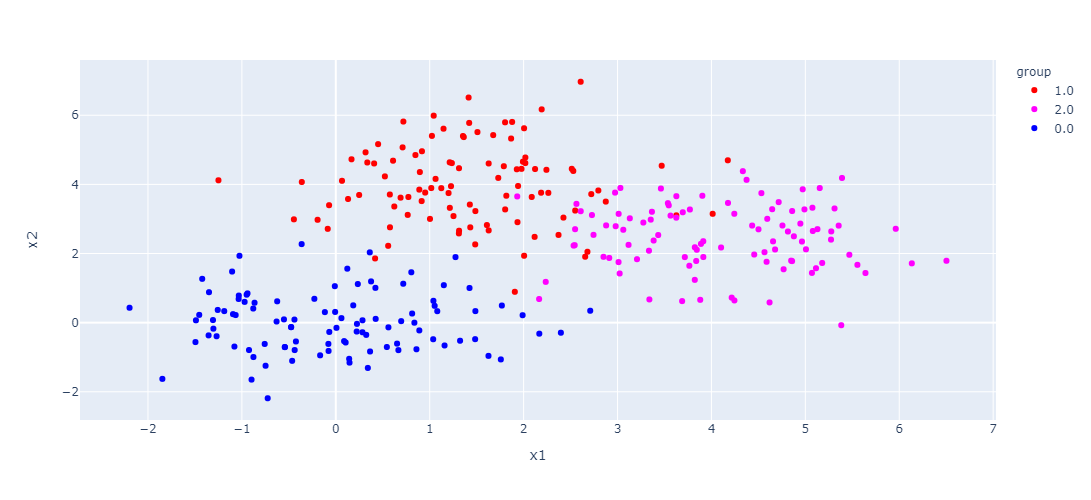

In [26]:
# sns.relplot(data=X_y, x='x1', y='x2', hue='group' )

# 将 簇标签 group 转成 字符型，避免绘制时作为连续变量映射到color
X_y['group'] = X_y['group'].astype(str)
# 这里自己指定了使用的离散色彩序列
fig = px.scatter(data_frame=X_y, x='x1', y='x2',color='group', color_discrete_sequence=["red", "magenta", "blue"])
fig.update_layout(width=800, height=500)
fig.show()

## Kmeans聚类

`KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, algorithm='auto')`
+ 参数
  + `init`,初始化算法，more是`k-means++`
  + `n_init`，使用不同质心进行运算的次数，默认=10


+ 属性
  + `cluster_centers_`，每个簇的质心
  + `labesl_`，每个样本对应的簇标号
  + `inertia_`，
  + `n_iter_`，迭代次数
  
如果数据量太大，可以使用一部分数据进行fit，然后使用predict来对剩余的数据进行聚类

In [5]:
# KMeans是类， k_means是函数
from sklearn.cluster import KMeans, k_means

In [6]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)

KMeans(n_clusters=3)

In [17]:
kmeans.n_clusters

3

In [10]:
# 最终每一簇的质心
kmeans.cluster_centers_

array([[ 4.08078522,  2.44579198],
       [-0.01424172,  0.03660202],
       [ 1.35507467,  4.1109045 ]])

In [67]:
kmeans.cluster_centers_[:,0]

array([ 4.08078522, -0.01424172,  1.35507467])

In [11]:
# 每个样本所属的簇标签
print(kmeans.labels_.shape)
kmeans.labels_[:5]

(300,)


array([2, 2, 2, 0, 2])

In [9]:
kmeans.inertia_

531.2258074643543

In [36]:
# 将原始数据和 聚类结果的簇标签结合起来，用于绘图
X_cluster = np.hstack([X, kmeans.labels_.reshape(-1,1)])
X_cluster = pd.DataFrame(X_cluster, columns=['x1','x2','cluster'])
X_cluster['cluster'] = X_cluster['cluster'].astype(str)

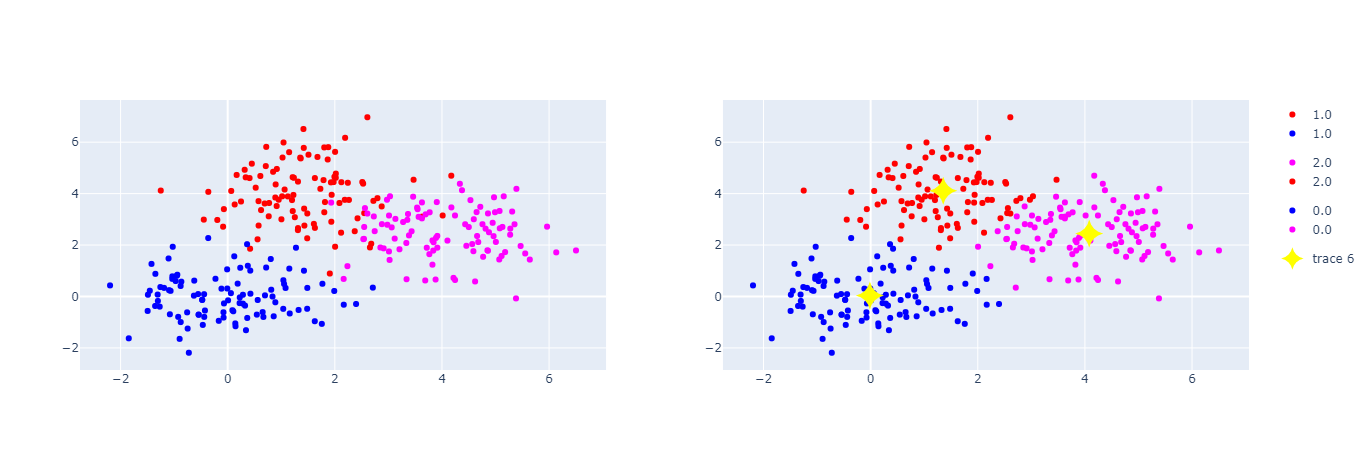

In [80]:
fig = make_subplots(rows=1, cols=2, column_widths=[600,600], row_heights=[600])

# 注意，这里 用于分组的 group 和 cluster 都是分类变量，所以返回的 fig1 和 fig2 里，都有 3 条 trace，对应于三个簇
fig1 = px.scatter(data_frame=X_y, x='x1', y='x2',color='group', color_discrete_sequence=["red", "magenta", "blue"])
fig2 = px.scatter(data_frame=X_cluster, x='x1', y='x2', color='cluster', color_discrete_sequence=["red", "magenta", "blue"])

# 这里不能使用 add_trace 方法，
fig.add_traces(fig1.data, rows=1, cols=1)
fig.add_traces(fig2.data, rows=1, cols=2)
fig.add_trace(
    go.Scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], 
               mode="markers",
               marker=dict(size=20, color='yellow', symbol='star-diamond')
    ), 
    row=1, col=2)

fig.show()

## KMeans聚类的效果评估

通常有两种方式：
1. “手肘”法
2. 轮廓系数



### 手肘法

`k` 从 1 取到 n (样本总数)，分别聚类，计算相应的簇内平方和（也就是 inertia），选择有拐点的那个k。

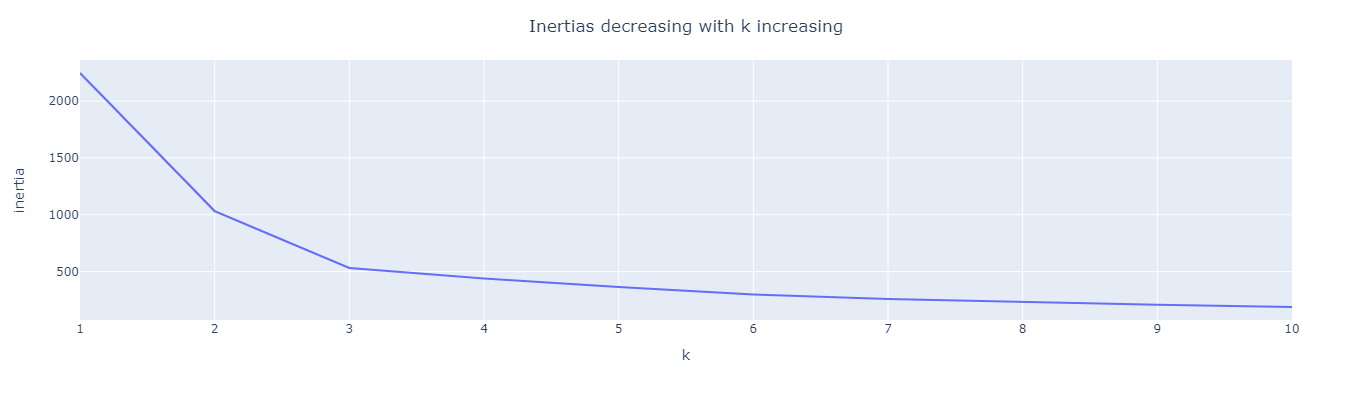

In [97]:
k_values = list(range(1, 11))
k_inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    k_inertias.append(kmeans.inertia_)
    
fig = px.line(x=k_values, y=k_inertias)
fig.update_layout(autosize=False, width=1000, height=400, xaxis_title="k", yaxis_title="inertia",
                  title=dict(text="Inertias decreasing with k increasing", x=0.5, y=0.95))
fig.show()

### 轮廓系数

对于单个样本来说，它的轮廓系数安装如下方式计算：

In [90]:
# 计算整个数据集的轮廓系数均值
from sklearn.metrics import silhouette_score
# 计算每个样本的轮廓系数
from sklearn.metrics import silhouette_samples

In [91]:
silhouette_score(X, result.labels_)

0.49422789699634107

In [92]:
s_samples = silhouette_samples(X, result.labels_)

In [93]:
s_samples.shape

(300,)

In [94]:
s_samples[:5]

array([0.59247868, 0.68893299, 0.67043253, 0.54491189, 0.62488703])

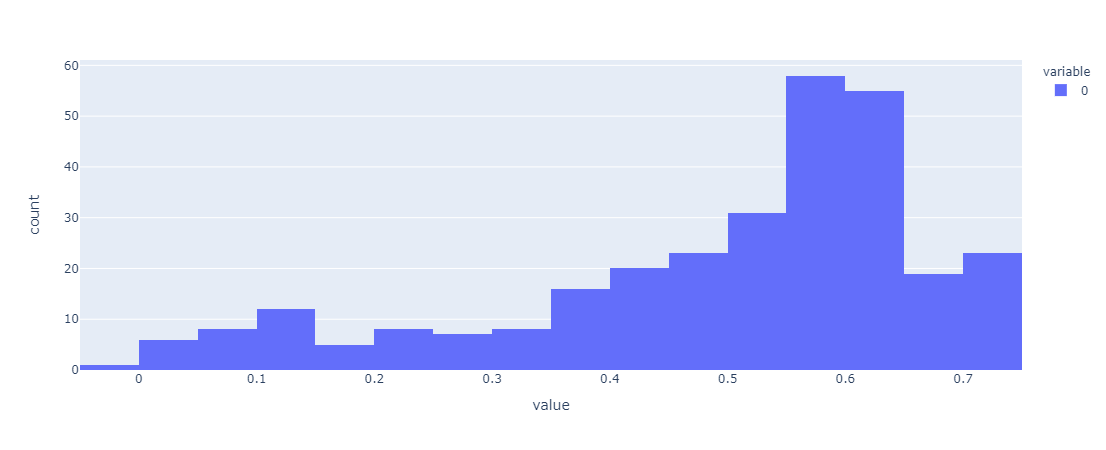

In [95]:
px.histogram(data_frame=s_samples)

## Mini-Batch Kmeans

Kmeans的改进，每一轮中，使用随机抽样的mini-batches来减少计算时间，效果会差一点，但一般不会差很多.

`MiniBatchKMeans(n_clusters=8, *, init='k-means++', max_iter=100, batch_size=100, verbose=0, compute_labels=True, random_state=None, tol=0.0, max_no_improvement=10, init_size=None, n_init=3, reassignment_ratio=0.01)`
+ 参数
  + `batch_size`，抽样的数据量

## MeanShift

`MeanShift(*, bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=None, max_iter=300)`
+ 参数
  + `bandwitdh`,RBF kernel使用的bandwidth
  + 

## KMean聚类做矢量量化

In [97]:
# 这个里面只有两张图片，一张颐和园的，一张花的
from sklearn.datasets import load_sample_image

In [100]:
# 颐和园图片
yiheyuan = load_sample_image('china.jpg')

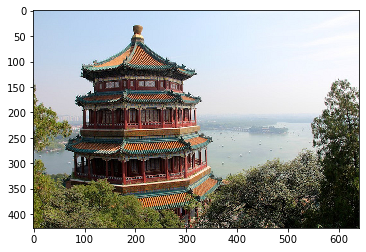

In [99]:
plt.imshow(yiheyuan)

# DBSCAN

`DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)`
+ 参数
  + `eps`，相邻点的半径
  + `min_samples`，核心点需要的点个数
  + `metric`，计算距离的定义


+ 属性
  + `core_sample_indices_`, Indices of core samples
  + `components_`, shape=`(n_core_samples, n_features)`, 核心点
  + `labels_`, 聚类和每个点的簇标签，噪声点的标签为 -1.

# 层次聚类

`AgglomerativeClustering(n_clusters=2, *, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)`

+ 参数
  + `affinity`, 用于计算两个簇之间的相邻度指标,
  

+ 属性
  + `n_clusters_`, 簇的数量
  + `labels_`, 每个点的簇标签
  + `n_leaves_`, 层次树的节点个数
  + `n_connected_components_`,
  + `children_`, 
  + `distance_`